#PART 1:The Kaolin library and differentiable renderers

In [1]:
!pip install torch==1.13.0+cu117 torchvision==0.14.0+cu117 torchaudio==0.13.0 --extra-index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu117
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 GB 983.0 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 24.6 MB/s eta 0:00:00
  Attempting uninstall: torch
    Found existing installation: torch 2.0.0+cu118
    Uninstalling torch-2.0.0+cu118:
      Successfully uninstalled torch-2.0.0+cu118
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.15.1+cu118
    Uninstalling torchvision-0.15.1+cu118:
      Successfully uninstalled torchvision-0.15.1+cu118
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 2.0.1+cu118
    Uninstalling torchaudio-2.0.1+cu118:
      Successfully uninstalled torchaudio-2.0.1+cu118
ERROR: pip's dependency resolver does not currently take into account all th

In [2]:
#@title Install Kaolin

!pip install kaolin==0.13.0 -f https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.13.1_cu116.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://nvidia-kaolin.s3.us-east-2.amazonaws.com/torch-1.13.1_cu116.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.6/95.6 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.2/427.2 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.3/24.3 MB 46.4 MB/s eta 0:00:00
  Attempting uninstall: tornado
    Found existing installation: tornado 6.2
    Uninstalling tornado-6.2:
      Successfully uninstalled tornado-6.2
  Attempting uninstall: flask
    Found existing installation: Flask 2.2.3
    Uninstalling Flask-2.2.3:
      Successfully uninstalled Flask-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0

In [3]:
#import modules

import torch
import kaolin as kal
import numpy as np
from PIL import Image

device = torch.device('cuda:0')

In [4]:
#@title get camera params from elevation, azimuth, radius
def get_camera_from_view(elev, azim, r=3.0):
    x = r * torch.cos(elev) * torch.cos(azim)
    y = r * torch.sin(elev)
    z = r * torch.cos(elev) * torch.sin(azim)

    pos = torch.tensor([x, y, z]).unsqueeze(0)
    look_at = -pos
    direction = torch.tensor([0.0, 1.0, 0.0]).unsqueeze(0)

    camera_proj = kal.render.camera.generate_transformation_matrix(pos, look_at, direction)
    return camera_proj

In [5]:
#Mesh class

class Mesh:
  def __init__(self, obj_path):
     mesh = kal.io.obj.import_mesh(obj_path, with_normals = True)
     self.vertices = mesh.vertices.to(device)
     self.faces = mesh.faces.to(device)
     self.vertex_normals = mesh.vertex_normals.to(device)
     self.normalize_mesh()
    
  def normalize_mesh(self):
    center = self.vertices.mean(dim = 0)
    v = self.vertices - center
    scale = torch.norm(v, dim = 1).max()
    v /= scale
    self.vertices = v

In [6]:
#Render single image from Mesh
lights = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).to(device)
camera_projection =kal.render.camera.generate_perspective_projection(np.pi / 3).to(device)
dim = (224, 224)
def render_single_view(mesh, elev=0, azim=0, show=False, lighting=True, background=None, radius=2,
                        return_mask=False):
    # if mesh is None:
    #     mesh = self._current_mesh
    verts = mesh.vertices
    faces = mesh.faces
    n_faces = faces.shape[0]

    face_attributes = torch.ones(1, n_faces, 3, 3).to(device) * 0.5


    camera_transform = get_camera_from_view(torch.tensor(elev), torch.tensor(azim), r=radius).to(device)
    face_vertices_camera, face_vertices_image, face_normals = kal.render.mesh.prepare_vertices(
        mesh.vertices.to(device), mesh.faces.to(device), camera_projection, camera_transform=camera_transform)

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        dim[1], dim[0], face_vertices_camera[:, :, :, -1],
        face_vertices_image, face_attributes, face_normals[:, :, -1])


    image = torch.clamp(image_features, 0.0, 1.0)
    if lighting:
        image_normals = face_normals[:, face_idx].squeeze(0)
        image_lighting = kal.render.mesh.spherical_harmonic_lighting(image_normals, lights).unsqueeze(0)
        image = image * image_lighting.repeat(1, 3, 1, 1).permute(0, 2, 3, 1).to(device)
        image = torch.clamp(image, 0.0, 1.0)

    return image

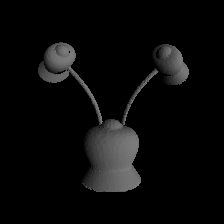

In [8]:
mesh = Mesh('./lamp.obj.txt')

image = render_single_view(mesh, elev = np.pi / 4)

Image.fromarray((image.squeeze(0).cpu().numpy() * 255.).astype('uint8'))

In [9]:
import imageio
from IPython.display import display, HTML
from base64 import b64encode
from tqdm.auto import tqdm
import cv2

mesh = Mesh('./lamp.obj.txt')
azim_list = np.arange(0, 2*np.pi, 0.01, dtype=np.float32)
video = imageio.get_writer('a4_part1_lamp_360_video.avi', mode='I', fps=30, codec='libx264', bitrate='16M')
for azim in azim_list:
    image = render_single_view(mesh, elev = np.pi / 3, azim = azim)
    video.append_data((image.squeeze(0).cpu().numpy() * 255.).astype('uint8'))
video.close()

!ffmpeg -y -i a4_part1_lamp_360_video.avi -pix_fmt yuv420p a4_part1_lamp_360_video.mp4 2> /dev/null
mp4 = open("a4_part1_lamp_360_video.mp4", "rb").read()
data_url = "data:a4_part1_lamp_360_video/mp4;base64," + b64encode(mp4).decode()
display(HTML(f"""
<video width={image.shape[1]} controls>
      <source src="{data_url}" type="video/mp4">
</video>
"""))

#PART 2: Text2Mesh (Video)

In [10]:

class Mesh:
  def __init__(self, obj_path):
     mesh = kal.io.obj.import_mesh(obj_path, with_normals = True)
     self.vertices = mesh.vertices[0::2].to(device)
     self.colors = mesh.vertices[1::2].to(device)
     #print(self.vertices[0][0])
     self.faces = mesh.faces.to(device)
     self.vertex_normals = mesh.vertex_normals.to(device)
     self.vertex_normals = torch.nn.functional.normalize(self.vertex_normals)
     #print(self.vertex_normals[0][0])
     self.normalize_mesh()
    
  def normalize_mesh(self):
    center = self.vertices.mean(dim = 0)
    v = self.vertices - center
    scale = torch.norm(v, dim = 1).max()
    v /= scale
    self.vertices = v

In [13]:
#Render single image from Mesh
lights = torch.tensor([1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]).to(device)
camera_projection =kal.render.camera.generate_perspective_projection(np.pi / 3).to(device)
dim = (224, 224)
def render_single_view(mesh, elev=0, azim=0, show=False, lighting=True, background=None, radius=2,
                        return_mask=False):

    verts = mesh.vertices[0::2]
    faces = mesh.faces
    #print("faces shape",faces.shape)
    n_faces = faces.shape[0]

    face_attributes = torch.ones(1, n_faces, 3, 3).to(device) * 0.5
    #print("face_attributes",face_attributes.shape)
    face_attributes[0,:,:] = mesh.colors[faces[:,:]]


    camera_transform = get_camera_from_view(torch.tensor(elev), torch.tensor(azim), r=radius).to(device)
    face_vertices_camera, face_vertices_image, face_normals = kal.render.mesh.prepare_vertices(
        mesh.vertices.to(device), mesh.faces.to(device), camera_projection, camera_transform=camera_transform)

    image_features, soft_mask, face_idx = kal.render.mesh.dibr_rasterization(
        dim[1], dim[0], face_vertices_camera[:, :, :, -1],
        face_vertices_image, face_attributes, face_normals[:, :, -1])


    image = torch.clamp(image_features, 0.0, 1.0)
    if lighting:
        image_normals = face_normals[:, face_idx].squeeze(0)
        image_lighting = kal.render.mesh.spherical_harmonic_lighting(image_normals, lights).unsqueeze(0)
        image = image * image_lighting.repeat(1, 3, 1, 1).permute(0, 2, 3, 1).to(device)
        image = torch.clamp(image, 0.0, 1.0)

    return image

In [14]:
import imageio
from IPython.display import display, HTML
from base64 import b64encode
from tqdm.auto import tqdm
import cv2
#from text2mesh import *
#import render as render


mesh = Mesh('./candle_final.obj')
azim_list = np.arange(0, 2*np.pi, 0.1, dtype=np.float32)
video = imageio.get_writer('a4_part2_candle_final.mp4', mode='I', fps=30, codec='libx264', bitrate='16M')
for azim in azim_list:
    image = render_single_view(mesh, elev = np.pi / 3, azim = azim)
    video.append_data((image.squeeze(0).cpu().numpy() * 255.).astype('uint8'))
video.close()

#!ffmpeg -y -i video.avi -pix_fmt yuv420p video.mp4 2> /dev/null
mp4 = open("a4_part2_candle_final.mp4", "rb").read()
data_url = "data:a4_part2_candle_final/mp4;base64," + b64encode(mp4).decode()
display(HTML(f"""
<video width={image.shape[1]} controls>
      <source src="{data_url}" type="video/mp4">
</video>
"""))

In [18]:
import imageio
from IPython.display import display, HTML
from base64 import b64encode
from tqdm.auto import tqdm
import cv2
#from text2mesh import *
#import render as render


mesh = Mesh('./horse_final.obj')
azim_list = np.arange(0, 2*np.pi, 0.1, dtype=np.float32)
video = imageio.get_writer('a4_part2_horse_final.mp4', mode='I', fps=30, codec='libx264', bitrate='16M')
for azim in azim_list:
    image = render_single_view(mesh, elev = np.pi / 6, azim = azim)
    video.append_data((image.squeeze(0).cpu().numpy() * 255.).astype('uint8'))
video.close()

#!ffmpeg -y -i video.avi -pix_fmt yuv420p video.mp4 2> /dev/null
mp4 = open("a4_part2_horse_final.mp4", "rb").read()
data_url = "data:a4_part2_horse_final/mp4;base64," + b64encode(mp4).decode()
display(HTML(f"""
<video width={image.shape[1]} controls>
      <source src="{data_url}" type="video/mp4">
</video>
"""))